In [1]:
%%bash
pip install -q openvino

In [2]:
import os
import cv2
import random as r
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Union
from openvino.runtime import Core

In [3]:
def preprocess(image: np.ndarray, width: int, height: int, model_name: str="facenet") -> np.ndarray:
    if model_name == "facenet":
        image = cv2.resize(src=image, dsize=(width, height), interpolation=cv2.INTER_AREA)
    else:
        image = cv2.resize(src=image, dsize=(width, height), interpolation=cv2.INTER_AREA).transpose(2, 0, 1)
    return np.expand_dims(image, axis=0)


def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float: return np.dot(a, b.reshape(-1, 1)) / (np.linalg.norm(a) * np.linalg.norm(b))


def setup(target: str, model_path: str) -> tuple:
    ie = Core()
    model = ie.read_model(model=model_path)
    model = ie.compile_model(model=model, device_name=target)

    input_layer = next(iter(model.inputs))
    output_layer = next(iter(model.outputs))

    return model, input_layer, output_layer, \
           (input_layer.shape[0], input_layer.shape[1], input_layer.shape[2], input_layer.shape[3])


def detect_faces(
    model, 
    output_layer, 
    image: np.ndarray, 
    w: int, 
    h: int,
    threshold: float=0.9,
) -> tuple:
    result = model(inputs=[image])[output_layer].squeeze()

    label_indexes: list = []
    probs: list = []
    boxes: list = []

    if result[0][0] == -1:
        return 0, None, None    
    else:
        for i in range(result.shape[0]):
            if result[i][0] == -1:
                break
            elif result[i][2] > threshold:
                label_indexes.append(int(result[i][1]))
                probs.append(result[i][2])
                boxes.append([int(result[i][3] * w), \
                              int(result[i][4] * h), \
                              int(result[i][5] * w), \
                              int(result[i][6] * h)])
            else:
                pass
        
    return label_indexes, probs, boxes


def show_images(
    image_1: np.ndarray,
    image_2: np.ndarray,
    cmap_1: str="gnuplot2",
    cmap_2: str="gnuplot2",
    title: Union[str, None]=None,
) -> None:
    """
        Display Image
    """
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(src=image_1, code=cv2.COLOR_BGR2RGB), cmap_1)
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(src=image_2, code=cv2.COLOR_BGR2RGB), cmap_2)
    plt.axis("off")
    if title: plt.suptitle(title, fontsize=28)
    plt.show()

In [4]:
known = os.listdir("../input/11-785-f22-hw2p2-verification/verification/known")
unknown_dev = sorted(os.listdir("../input/11-785-f22-hw2p2-verification/verification/unknown_dev"))
df = pd.read_csv("../input/11-785-f22-hw2p2-verification/verification/dev_identities.csv")

BASE_PATH: str = "../input/11-785-f22-hw2p2-verification/verification"
clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(5, 5))

### **Generate Index**

In [5]:
index: int = r.randint(1, 10)

### **Only Facial Recognition**

In [6]:
filename: str = os.listdir(f"{BASE_PATH}/known/{df.label[index]}")[0]
image_from_known: np.ndarray = cv2.imread(f"{BASE_PATH}/known/{df.label[index]}/{filename}", cv2.IMREAD_COLOR)
image_from_unknown: np.ndarray = cv2.imread(f"{BASE_PATH}/unknown_dev/{unknown_dev[index]}", cv2.IMREAD_COLOR)
    
disp_image_1 = image_from_known.copy()
disp_image_2 = image_from_unknown.copy()

for i in range(3):
    image_from_known[:, :, i] = clahe.apply(image_from_known[:, :, i])
    image_from_unknown[:, :, i] = clahe.apply(image_from_unknown[:, :, i])

temp_image_1 = image_from_known.copy()
temp_image_2 = image_from_unknown.copy()

h1, w1, _ = image_from_known.shape
h2, w2, _ = image_from_unknown.shape

# show_images(disp_image_1, disp_image_2)

r_model, _, r_output_layer, (_, r_H, r_W, _) = setup("CPU", "../input/ovfacemodels/recog_model_2.xml")

image_from_known = preprocess(image_from_known, r_W, r_H, "facenet")
image_from_unknown = preprocess(image_from_unknown, r_W, r_H, "facenet") 

image_from_known_embeddings = r_model(inputs=[image_from_known])[r_output_layer]
image_from_unknown_embeddings = r_model(inputs=[image_from_unknown])[r_output_layer]

# print("\n" + 50*"*" + "\n")
# print(f"Cosine Similarity : {cosine_similarity(image_from_known_embeddings, image_from_unknown_embeddings)[0][0]:.5f}")
# print("\n" + 50*"*" + "\n")

cs_1 = cosine_similarity(image_from_known_embeddings, image_from_unknown_embeddings)[0][0]

### **Facial Detection & Recognition**

In [7]:
filename: str = os.listdir(f"{BASE_PATH}/known/{df.label[index]}")[0]
image_from_known: np.ndarray = cv2.imread(f"{BASE_PATH}/known/{df.label[index]}/{filename}", cv2.IMREAD_COLOR)
image_from_unknown: np.ndarray = cv2.imread(f"{BASE_PATH}/unknown_dev/{unknown_dev[index]}", cv2.IMREAD_COLOR)
    
h1, w1, _ = image_from_known.shape
h2, w2, _ = image_from_unknown.shape

disp_image_1 = image_from_known.copy()
disp_image_2 = image_from_unknown.copy()

for i in range(3):
    image_from_known[:, :, i] = clahe.apply(image_from_known[:, :, i])
    image_from_unknown[:, :, i] = clahe.apply(image_from_unknown[:, :, i])

temp_image_1 = image_from_known.copy()
temp_image_2 = image_from_unknown.copy()

# show_images(disp_image_1, disp_image_2)

d_model, _, d_output_layer, (_, _, d_H, d_W) = setup("CPU", "../input/ovfacemodels/detect_model.xml")
r_model, _, r_output_layer, (_, r_H, r_W, _) = setup("CPU", "../input/ovfacemodels/recog_model_2.xml")

image_from_known = preprocess(image_from_known, d_W, d_H, "other")
image_from_unknown = preprocess(image_from_unknown, d_W, d_H, "other")

label_indexes_1, probs_1, boxes_1 = detect_faces(d_model, d_output_layer, image_from_known, w1, h1)
label_indexes_2, probs_2, boxes_2 = detect_faces(d_model, d_output_layer, image_from_unknown, w2, h2)

image_from_known = preprocess(temp_image_1[boxes_1[0][1]:boxes_1[0][3], boxes_1[0][0]:boxes_1[0][2], :], r_W, r_H, "facenet")
image_from_unknown = preprocess(temp_image_2[boxes_2[0][1]:boxes_2[0][3], boxes_2[0][0]:boxes_2[0][2], :], r_W, r_H, "facenet")

image_from_known_embeddings = r_model(inputs=[image_from_known])[r_output_layer]
image_from_unknown_embeddings = r_model(inputs=[image_from_unknown])[r_output_layer]

# print("\n" + 50*"*" + "\n")
# print(f"Cosine Similarity : {cosine_similarity(image_from_known_embeddings, image_from_unknown_embeddings)[0][0]:.5f}")
# print("\n" + 50*"*" + "\n")

cs_2 = cosine_similarity(image_from_known_embeddings, image_from_unknown_embeddings)[0][0]

### **Test**

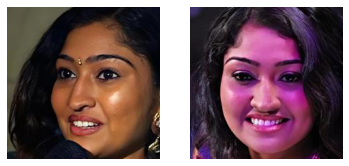

In [8]:
show_images(disp_image_1, disp_image_2)

In [9]:
print(f"Cosine Similarity (FR Only) : {cs_1:.5f}")
print(f"Cosine Similarity (FD + FR) : {cs_2:.5f}")

Cosine Similarity (FR Only) : 0.82353
Cosine Similarity (FD + FR) : 0.68039
